## 주식 종가와 뉴스 감정 점수 비교 시각화

### 데이터 로드 및 초기 처리
- SK 하이닉스의 주가 데이터를 `FinanceDataReader`를 사용하여 종가 추출
- 뉴스 감정 점수 데이터를 CSV 파일로부터 로드한 후, `day`를 인덱스로 설정

In [2]:
# 라이브러리 불러오기
import re
import FinanceDataReader as fdr
from matplotlib.dates import DateFormatter, DayLocator
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# SK Hynix(000660) 주가 데이터 불러오기
stock_prices = fdr.DataReader('000660', '2024-11-04', '2024-11-29')['Close']

# 감정 점수 데이터 불러오기 (CSV 파일)
sentiment_scores = pd.read_csv('../data/sentiment_scores_by_day.csv', header=0)

# 'day' 컬럼을 datetime 형식으로 변환
sentiment_scores['day'] = pd.to_datetime(sentiment_scores['day'])

# 'day'를 인덱스로 설정
sentiment_scores.set_index('day', inplace=True)

# 데이터 확인
print(f"주가 데이터:\n{stock_prices.head()}")
print(f"감정 데이터:\n{sentiment_scores.head()}")

주가 데이터:
Date
2024-11-04    194000
2024-11-05    193200
2024-11-06    195800
2024-11-07    197400
2024-11-08    200500
Name: Close, dtype: int64
감정 데이터:
            sentiment_score
day                        
2024-11-04              378
2024-11-05               55
2024-11-06               41
2024-11-07              -46
2024-11-08               35


---
### 금요일과 주말 평균 감정 점수 계산
- 주말에는 주가데이터가 없기 때문에, **금요일과 주말(토, 일)의 감정 점수를 평균 내어** 금요일 점수로 업데이트

In [3]:
# 금요일과 주말(토요일, 일요일) 감정 점수의 평균 계산
for date in sentiment_scores.index:
    if date.weekday() == 4:  # 금요일 (weekday 값: 4)
        friday_score = sentiment_scores.loc[date, 'sentiment_score']
        saturday_score = sentiment_scores.loc[date + pd.Timedelta(days=1), 'sentiment_score'] if date + pd.Timedelta(days=1) in sentiment_scores.index else None
        sunday_score = sentiment_scores.loc[date + pd.Timedelta(days=2), 'sentiment_score'] if date + pd.Timedelta(days=2) in sentiment_scores.index else None

        # 주말 점수가 None인 경우 처리
        scores = [friday_score]
        if saturday_score is not None:
            scores.append(saturday_score)
        if sunday_score is not None:
            scores.append(sunday_score)

        # 금요일, 토요일, 일요일 평균 감정 점수 계산
        weekend_avg_score = sum(scores) / len(scores)

        # 금요일에 해당 주의 평균 감정 점수를 업데이트
        sentiment_scores.loc[date, 'sentiment_score'] = weekend_avg_score

# 데이터 확인
sentiment_scores.head()

,sentiment_score
day,
2024-11-04,378.0
2024-11-05,55.0
2024-11-06,41.0
2024-11-07,-46.0
2024-11-08,15.0


---
### 감정 점수 긍정/부정 분류
- 감정 점수가 0 이상이면 긍정, 0 미만이면 부정으로 분류

In [4]:
# 감정 점수 구간 나누기 (0 이상은 긍정, 0 미만은 부정)
sentiment_scores['sentiment_type'] = sentiment_scores['sentiment_score'].apply(
    lambda x: 'Positive' if x >= 0 else 'Negative'
)

# 데이터 확인
sentiment_scores.head()

,sentiment_score,sentiment_type
day,,
2024-11-04,378.0,Positive
2024-11-05,55.0,Positive
2024-11-06,41.0,Positive
2024-11-07,-46.0,Negative
2024-11-08,15.0,Positive


---
### 주가와 감정 점수 데이터 병합
- 날짜 인덱스를 기준으로 SK 하이닉스 주가 데이터와 뉴스 감정 점수 데이터 병합

In [5]:
# 주가 데이터와 감정 점수 데이터를 날짜 인덱스를 기준으로 결합
merged_data = pd.merge(stock_prices, sentiment_scores[['sentiment_score', 'sentiment_type']], left_index=True, right_index=True, how='inner')

# 데이터 확인
merged_data.head()

,Close,sentiment_score,sentiment_type
2024-11-04,194000,378.0,Positive
2024-11-05,193200,55.0,Positive
2024-11-06,195800,41.0,Positive
2024-11-07,197400,-46.0,Negative
2024-11-08,200500,15.0,Positive


---
### 데이터 시각화
- SK 하이닉스 종가와 뉴스 감정 점수를 같은 날짜 축에서 시각화
- 긍정/부정 감정 점수에 따라 배경색을 변경하여 직관적으로 표현

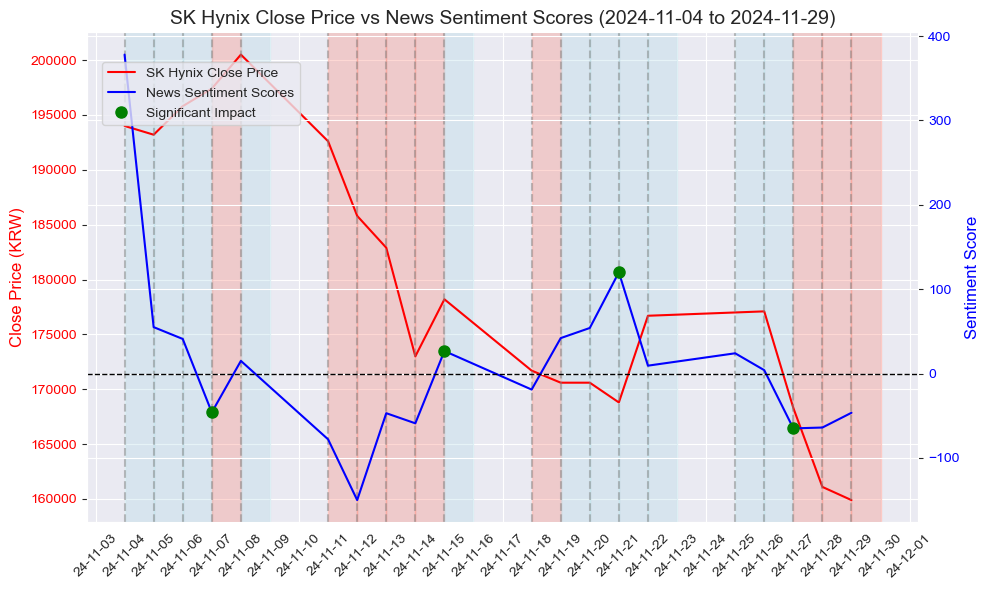

In [6]:
# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 축: SK Hynix 종가 데이터
ax1.plot(merged_data.index, merged_data['Close'], label='SK Hynix Close Price', color='red')
ax1.set_ylabel('Close Price (KRW)', fontsize=12, color='red')
ax1.tick_params(axis='y', labelcolor='red')

# 두 번째 축: 감정 점수 데이터
ax2 = ax1.twinx()
ax2.plot(merged_data.index, merged_data['sentiment_score'], label='News Sentiment Scores', color='blue')
ax2.set_ylabel('Sentiment Score', fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# 감정 점수 y축에서 0 라인에 수평선 추가
ax2.axhline(0, color='black', linestyle='--', linewidth=1)

# 긍정/부정에 따라 배경 색상 변경
for date, sentiment in merged_data['sentiment_type'].items():
    if sentiment == 'Positive':
        ax1.axvspan(date, date + pd.Timedelta(days=1), color='lightblue', alpha=0.3)  # 긍정
    else:
        ax1.axvspan(date, date + pd.Timedelta(days=1), color='salmon', alpha=0.3)   # 부정
    
# 각 날짜마다 수직선 추가
for date in merged_data.index:
    ax1.axvline(x=date, color='gray', linestyle='--', alpha=0.5)

# 특정 날짜에 동그라미 마커 추가 (11.07, 15, 21, 27)
highlight_dates = ['2024-11-07', '2024-11-15', '2024-11-21', '2024-11-27']
highlight_dates = pd.to_datetime(highlight_dates)

# 동그라미 마커 추가
ax2.plot(merged_data.loc[highlight_dates].index, merged_data.loc[highlight_dates, 'sentiment_score'], 
         'o', color='green', markersize=8, label='Significant Impact')

# x축의 날짜 포맷 설정
ax1.xaxis.set_major_locator(DayLocator())
ax1.xaxis.set_major_formatter(DateFormatter('%y-%m-%d'))
ax1.tick_params(axis='x', rotation=45)

# 그래프 제목 및 레이블
plt.title('SK Hynix Close Price vs News Sentiment Scores (2024-11-04 to 2024-11-29)', fontsize=14)

# 범례 추가
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# 그리드와 레이아웃
plt.grid(True)
plt.tight_layout()

# 그래프 출력
plt.show()

### 주가와의 상관관계가 시각적으로 보이는 날짜의 워드클라우드 시각화
- `2024-11-07 (-46)`: SK하이닉스 전 직원이 핵심기술을 중국으로 빼돌려 1심에서 실형, 미국 트럼프 대통령의 보조금 삭감
- `2024-11-15 (+26.67)`: 산학연구과제 우수발명 포상
- `2024-11-21 (+120)`: 세계 최초 321단 4D 낸드플래시 양산 시작
- `2024-11-27 (-65)`: 주가가 계속 하락함에 따라 주주환원정책을 확대하여 주당 고정배당금을 25% 상향 발표, 하지만 최근 주가의 하락에 관해 부정적인 뉴스가 감정 점수에 큰 영향을 미침

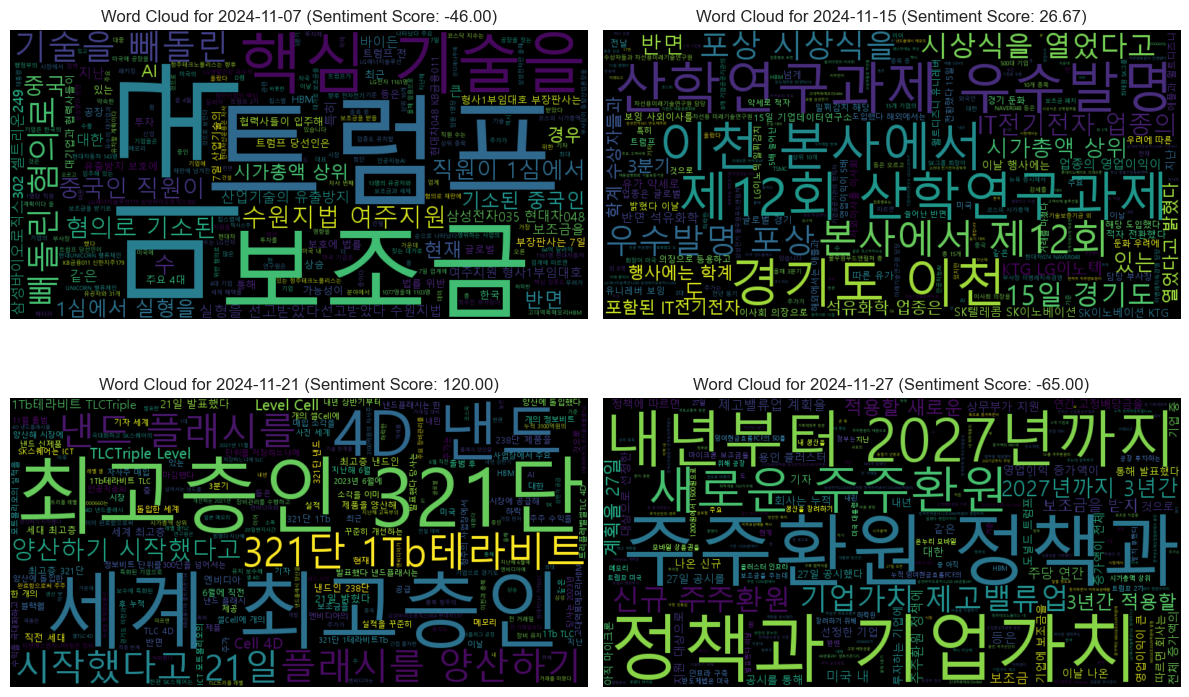

In [7]:
# 데이터 로드
dataset = pd.read_csv('../data/naver_news_crawling_data_with_sentiment.csv', header=0)

# 'pub_date' 컬럼을 datetime 형식으로 변환 (에러 발생 시 'coerce' 사용)
dataset['pub_date'] = pd.to_datetime(dataset['pub_date'], errors='coerce')

# 'pub_date'에서 날짜만 추출 (시간 제거)
dataset['date_only'] = dataset['pub_date'].dt.date

# 특정 날짜들 필터링
highlight_dates = ['2024-11-07', '2024-11-15', '2024-11-21', '2024-11-27']
highlight_dates = pd.to_datetime(highlight_dates).date  # 날짜 형식으로 변환

# 불용어 파일 로드
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())
    return stopwords

# 불용어 리스트 로드
stop_words = load_stopwords('../stopwords.txt')

# 불용어를 포함하는 단어를 정규 표현식으로 제거
def remove_stopwords(text, stop_words):
    for word in stop_words:
        text = re.sub(r'\b' + re.escape(word) + r'(?:\s*(?:와|과|이|가|도|는|의|을|를|와|의|에|에서)*)\b', '', text)
    return text

# 서브플롯 설정 (2행 2열)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 특정 날짜별로 워드클라우드 생성 및 출력
for i, date in enumerate(highlight_dates):
    # 해당 서브플롯 위치 계산 (2x2 배열에서 위치 지정)
    ax = axes[i//2, i%2]  # (행, 열) 순으로 서브플롯 위치 결정

    # 특정 날짜의 데이터 필터링
    filtered_data = dataset[dataset['date_only'] == date]
    
    # 필터링된 데이터에서 'description' 컬럼에 결측값이 없는 데이터만 선택
    filtered_data = filtered_data.dropna(subset=['description'])

    # 'description' 컬럼에서 텍스트 추출
    text_data = ' '.join(filtered_data['description'])

    # 불용어 제거
    text_data = remove_stopwords(text_data, stop_words)

    # merged_data에서 해당 날짜의 감정점수 가져오기
    sentiment_score = merged_data.loc[merged_data.index.date == date, 'sentiment_score'].values[0]

    # 워드클라우드 생성
    wordcloud = WordCloud(font_path='malgun', stopwords=stop_words, width=800, height=400).generate(text_data)

    # 워드클라우드 시각화
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for {date} (Sentiment Score: {sentiment_score:.2f})')

# 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()


---
### 결론
- 수집한 뉴스 데이터의 양이 적고 기간이 짧아 정확한 상관관계를 도출하기 어려운 한계가 있었습니다.
- 하지만 전반적으로 주가의 상승과 하락에 따라 뉴스 감정 데이터가 비슷한 흐름을 보였으며, 특히 2024-11-07과 2024-11-21과 같이 전날의 뉴스 감정 상태에 따라 주가가 변동하는 양상이 관찰되었습니다.
- 이를 통해 뉴스 감정 분석의 정확도가 비교적 잘 이루어진 것으로 보이며, 데이터 수집 기간을 연장하고 뉴스의 질적 분류를 보강한다면 더욱 신뢰할 수 있는 분석 결과를 기대할 수 있을 것입니다.